# Face Recognition Assignment #1

## Problem Statement 

We intend to perform face recognition. Face recognition means that for a given image
you can tell the subject id. Our database of subject is very simple. It has 40 subjects.
Below we will show the needed steps to achieve the goal of the assignment.

### Step 1: Download the dataset and understand the format 

In [0]:
from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images
    foldersList = listdir(path)
    loadedImages = []
    for folder in foldersList :
        imagesList = listdir(path+'/'+folder)
        for image in imagesList:
            img = PImage.open(path +'/'+folder+'/'+ image)
            loadedImages.append(img)
    return loadedImages

In [0]:
#Loading the data from google drive 

from google.colab import drive
drive.mount('/content/drive')
!tar xf ./drive/My\ Drive/dataset.tar -C ./

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

path = "./orl_faces"
# your images in an array
imgs = loadImages(path)

### Step 2: Generate the Data Matrix and the Label vector 

In [0]:
import numpy as np
dataMatrix = np.arange(4121600).reshape(400,10304)
j=0
label = []
for i in range(0,400) :
    if(i%10 == 0):
        j = j+1
    dataMatrix[i] = np.array(imgs[i]).flatten()
    label.append(j)

### Step 3: Splitting the dataset into training and test sets

In [0]:
trainSet=np.arange(2885120).reshape(280,10304)
testSet=np.arange(1236480).reshape(120,10304)
trainLabel= np.arange(280).reshape(280,1)
testLabel= np.arange(120).reshape(120,1)

j,k=7,3
classLabel=1
for i in range(0,401,10):
    if( i != 0 ):
        trainSet[j-7:j,:]=dataMatrix[i-10:i-3,:]
        testSet[k-3:k,:]=dataMatrix[i-3:i,:]
        trainLabel[j-7:j]= np.full((7,1), classLabel, dtype=int)
        testLabel[k-3:k]= np.full((3,1), classLabel, dtype=int)
        classLabel+=1
        j+=7
        k+=3

### Step 4: Classification using PCA

In [0]:
#calculate mean face of the training set.
trainMean=np.mean(trainSet,axis=0)
#subtract the mean face from the training set.
centerTrainMatrix=trainSet-trainMean
#compute the covariance matrix from obtained centered data matrix.
covMatrix=np.cov(centerTrainMatrix, rowvar=False, bias=True)


In [0]:
#displaying the mean face of the training data set.
plt.imshow(trainMean.reshape(112,92), cmap='gray');

In [0]:
#compute eigen vectors and values from obtained covariance matrix.
eigVal,eigVectMatrix=np.linalg.eigh(covMatrix)
#flip both eigen values and vectors in order to be sorted descendingly.
eigVal=np.flip(eigVal,axis=0)
eigVectMatrix=np.flip(eigVectMatrix,axis=1)

In [0]:
#displaying the largest three eigen vectors as images.
eigenFace1 = eigVectMatrix[:,0].reshape(112,92)
eigenFace2 = eigVectMatrix[:,1].reshape(112,92)
eigenFace3 = eigVectMatrix[:,2].reshape(112,92)
plt.imshow(eigenFace1, cmap='gray');
plt.figure()
plt.imshow(eigenFace2, cmap='gray');
plt.figure()
plt.imshow(eigenFace3, cmap='gray');

In [0]:
#utility method to compute the dimenison required for the specificed alpha value. 
def computeDimensionality(eigVal,threshold):
    totalDataVariance=np.sum(eigVal)
    varianceFraction,numDim,eigValSum=0,1,0
    
    while(varianceFraction<threshold):
        eigValSum+=eigVal[numDim-1]
        varianceFraction=eigValSum/totalDataVariance
        numDim+=1
    return numDim

In [0]:
#Calculating dimension needed for four alpha values ( 0.8 , 0.85 , 0.9 , 0.95)
dimAlpha1=computeDimensionality(eigVal,0.8)
dimAlpha2=computeDimensionality(eigVal,0.85)
dimAlpha3=computeDimensionality(eigVal,0.9)
dimAlpha4=computeDimensionality(eigVal,0.95)

In [0]:
#Computing the projection matrix, one for each alpha value.
projMat1=eigVectMatrix[:,0:dimAlpha1]
projMat2=eigVectMatrix[:,0:dimAlpha2]
projMat3=eigVectMatrix[:,0:dimAlpha3]
projMat4=eigVectMatrix[:,0:dimAlpha4]


In [0]:
#Projecting the tarining data instances on the new basis.
reducedDimTrain1= (projMat1.T @ centerTrainMatrix.T)
reducedDimTrain2= (projMat2.T @ centerTrainMatrix.T)
reducedDimTrain3= (projMat3.T @ centerTrainMatrix.T)
reducedDimTrain4= (projMat4.T @ centerTrainMatrix.T)


In [0]:
#calculate mean face of the test set.
testMean = np.mean(testSet,axis=0)
#subtract the mean face from the test set to obtain centered data matrix
centerTestMatrix = testSet-testMean
#Projecting the test data instances on the new basis.
reducedDimTest1=projMat1.T @ centerTestMatrix.T
reducedDimTest2=projMat2.T @ centerTestMatrix.T
reducedDimTest3=projMat3.T @ centerTestMatrix.T
reducedDimTest4=projMat4.T @ centerTestMatrix.T

In [0]:
#Reconstruction of a face using PCA eigen vectors ,where alpha = 0.95 
reconstrutedfaces = (reducedDimTrain4.T @ projMat4.T ) + trainMean
#Comparing the reconstructed face and the original face 
plt.imshow(reconstrutedfaces[50].reshape(112,92), cmap='gray');
plt.figure()
plt.imshow(trainSet[50].reshape(112,92), cmap='gray');

In [0]:
#import the KNeighborsClassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier
#import metrics model to check the accuracy 
from sklearn import metrics
# utility method to apply the knn classifier and return the score resulted.
def knn(trainingSet,trainingLabel,testSet,testLabel,k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(trainingSet,trainLabel)
    pred=knn.predict(testSet)
    score  = metrics.accuracy_score(testLabel,pred)
    return score

In [0]:
knn(reducedDimTrain1.T,trainLabel,reducedDimTest1.T,testLabel,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.6166666666666667

In [0]:
knn(reducedDimTrain2.T,trainLabel,reducedDimTest2.T,testLabel,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.65

In [0]:
knn(reducedDimTrain3.T,trainLabel,reducedDimTest3.T,testLabel,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.6666666666666666

In [0]:
knn(reducedDimTrain4.T,trainLabel,reducedDimTest4.T,testLabel,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.7333333333333333

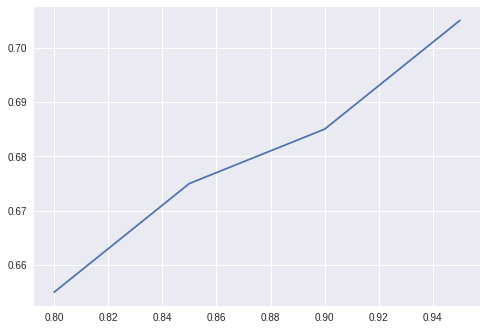

In [0]:
import matplotlib.pyplot as plt
plt.plot([0.8,0.85,0.9,0.95],[0.655,0.675,0.685,0.705]);

### Step 5: Classification using LDA

In [0]:
dataClassList=[]
for i in range(0,281):
    if(i%7==0 and i!=0):
        dataClassList.append(trainSet[i-7:i,:])

In [0]:
mean=np.mean(dataClassList,axis=1)

In [0]:
withinClassScatterMatrix = np.zeros((10304,10304))
for i in range(0,40):
    diffMatrix = (dataClassList[i]-mean[i])
    withinClassScatterMatrix += diffMatrix.T @ diffMatrix

In [0]:
overallSampleMean = 1/40* np.sum(mean, axis =0)

In [0]:
betweenClassScatterMatrix = np.zeros((10304,10304))
for i in range(0,40):
    diffVector = (mean[i]- overallSampleMean)
    betweenClassScatterMatrix  += np.outer(diffVector,diffVector) 

In [0]:
withinClassScatterMatrixInv = np.linalg.pinv(withinClassScatterMatrix)

In [0]:
sinverse_b = withinClassScatterMatrixInv @ betweenClassScatterMatrix

In [0]:
eigValLDA,eigVectMatrixLDA = np.linalg.eig(sinverse_b)

In [0]:
idx = eigValLDA.argsort()[-39:][::-1]
sortedEigVectMatrixLDA = np.real(eigVectMatrixLDA[:,idx])

In [0]:
reducedDimTrainLDA = sortedEigVectMatrixLDA.T @ trainSet.T
reducedDimTestLDA = sortedEigVectMatrixLDA.T @ testSet.T

In [0]:
knn(reducedDimTrainLDA.T,trainLabel,reducedDimTestLDA.T,testLabel,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.4583333333333333

### Step 6: Classifier Tuning 

In [0]:
LDAscoreList = []
for k in range(1,8,2):
    LDAscoreList.append(knn(reducedDimTrainLDA.T,trainLabel,reducedDimTestLDA.T,testLabel,k))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


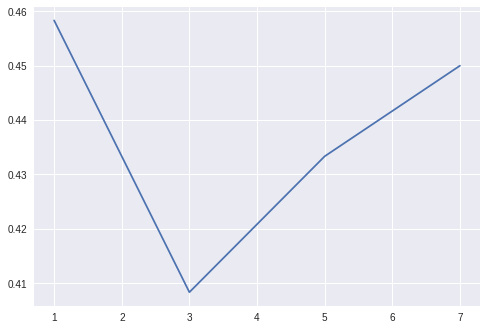

In [0]:
plt.plot([1,3,5,7],LDAscoreList);

In [0]:
PCAscoreList = []
for k in range(1,8,2):
    PCAscoreList.append(knn(reducedDimTrain4.T,trainLabel,reducedDimTest4.T,testLabel,k))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


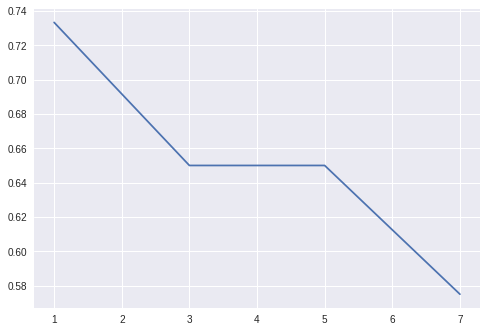

In [0]:
plt.plot([1,3,5,7],PCAscoreList);